In this assignment you'll have to explore and classify time series. The dataset is [FordA](http://www.timeseriesclassification.com/description.php?Dataset=FordA), which is a set of recordings of engine noise under typical conditions and you need to classify if certain condition exists.

In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plotting improts
import seaborn as sns

In [3]:
# Generic imports
import pathlib

# DS imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report


## Constants

In [4]:
DATA_DIR = pathlib.Path("data/")
DATASET = "FordA"

# Loading the data

Data files are stored in tabular format:

In [5]:
!head -n 2 data/FordA/FordA_TRAIN.txt

'head' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
train = pd.read_csv(DATA_DIR.joinpath(DATASET, f"{DATASET}_TRAIN.txt"),
                    header=None,
                    sep="\s+",
                    skipinitialspace=True)
test = pd.read_csv(DATA_DIR.joinpath(DATASET, f"{DATASET}_TEST.txt"),
                   header=None,
                   sep="\s+",
                   skipinitialspace=True)

In [7]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


So, each row represents a single measurement, with column `0` being class label, and columns `1-501` being measured values. Let's check missing values:

In [8]:
train.notnull().sum(axis=1).unique()

array([501], dtype=int64)

In [9]:
test.notnull().sum(axis=1).unique()

array([501], dtype=int64)

Let's change column names to something meaningful:

In [10]:
train.rename({0: "label"}, axis=1, inplace=True)
test.rename({0: "label"}, axis=1, inplace=True)

In [11]:
train.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)
test.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)

We can now select data values by filtering:

In [12]:
train.filter(like="val_")

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.196022,-0.070102,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.025217,0.233320,0.350545,...,1.715205,1.129082,0.528158,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.316612,-2.603753
3597,0.041994,0.422255,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,0.421544,...,-0.463329,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755
3598,-0.570054,-0.333165,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,0.275412,1.153586,2.035725,...,0.902821,0.579700,0.157463,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.942733,-0.270722
3599,2.006732,2.079150,2.022036,1.867560,1.648112,1.379446,1.093717,0.784057,0.434150,0.029284,...,1.268671,1.148971,0.928088,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.441231,-0.280709


The dataset is almost balanced:

In [13]:
train.iloc[:, 0].value_counts()

-1.0    1846
 1.0    1755
Name: label, dtype: int64

In [14]:
test.iloc[:, 0].value_counts()

-1.0    681
 1.0    639
Name: label, dtype: int64

# Task 1: explore time series

In this task you need to plot data samples with class label designation. Consider 10 or 20 random samples, and create a `2 x 5` or `4 x 5` plot, with eash subplot being the data records (i. e. `train.filter(like="val_").iloc[<sample_idx>]`), subtitles displaying sample index and class label. You can use color as well.

In [15]:
N_SAMPLES = 20
N_COLS = 5
N_ROWS = 20 // N_COLS

samples = train.sample(N_SAMPLES, replace=False)

In [16]:
samples

,label,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
2554,1.0,0.206768,0.246748,0.206967,0.118728,0.008744,-0.115767,-0.258327,-0.409731,-0.549101,...,-0.841266,-0.637202,-0.495253,-0.452673,-0.500552,-0.613962,-0.745417,-0.849600,-0.876380,-0.782784
1971,-1.0,-1.599540,-1.760246,-1.875036,-1.940631,-1.940631,-1.901274,-1.809442,-1.668414,-1.442114,...,-1.012471,-1.130541,-1.163338,-1.123981,-1.019030,-0.861604,-0.658261,-0.409003,-0.113172,0.217095
422,1.0,-1.314351,-1.729312,-2.010547,-2.130233,-2.068644,-1.832542,-1.451869,-0.975183,-0.462413,...,1.051961,1.331615,1.552757,1.710092,1.789535,1.774354,1.664304,1.452200,1.141589,0.738201
1411,1.0,-1.024026,-1.123801,-1.070477,-0.847912,-0.469578,0.002868,0.493046,0.921747,1.226033,...,1.417991,1.187974,0.854265,0.421313,-0.099242,-0.672952,-1.229404,-1.698648,-2.011140,-2.136948
360,1.0,-0.606212,-0.923299,-1.071263,-1.015646,-0.800390,-0.496734,-0.203637,0.019432,0.136244,...,0.934883,0.816129,0.580315,0.281125,-0.043392,-0.315566,-0.509756,-0.585539,-0.530637,-0.370519
3190,-1.0,-0.193972,-0.136623,-0.087987,-0.060021,-0.051307,-0.054752,-0.058197,-0.047660,-0.020505,...,-0.069141,-0.398647,-0.787733,-1.221401,-1.638857,-1.969175,-2.131294,-2.090764,-1.843533,-1.422023
2073,-1.0,0.695244,0.466213,-0.036288,-0.629718,-1.089148,-1.280577,-1.157516,-0.774658,-0.305656,...,0.265212,0.504499,0.804632,1.112286,1.296878,1.214837,0.831979,0.182488,-0.590749,-1.266904
595,1.0,-1.053926,-0.961637,-0.722552,-0.338543,0.147454,0.677792,1.169180,1.538711,1.726109,...,-0.454516,-0.296388,-0.115825,0.033229,0.132032,0.175473,0.174896,0.130978,0.055085,-0.040606
2717,1.0,2.872373,2.978378,2.898892,2.633935,2.195136,1.602053,0.893779,0.121260,-0.664361,...,1.485521,1.352924,1.112762,0.786044,0.403704,0.000063,-0.386501,-0.726055,-0.995815,-1.188284
2692,1.0,-0.714181,-0.570014,-0.386829,-0.122193,0.217556,0.597313,0.966109,1.266129,1.448140,...,-0.596322,-0.808506,-0.953247,-1.026154,-1.018077,-0.931926,-0.765082,-0.520741,-0.229396,0.054187


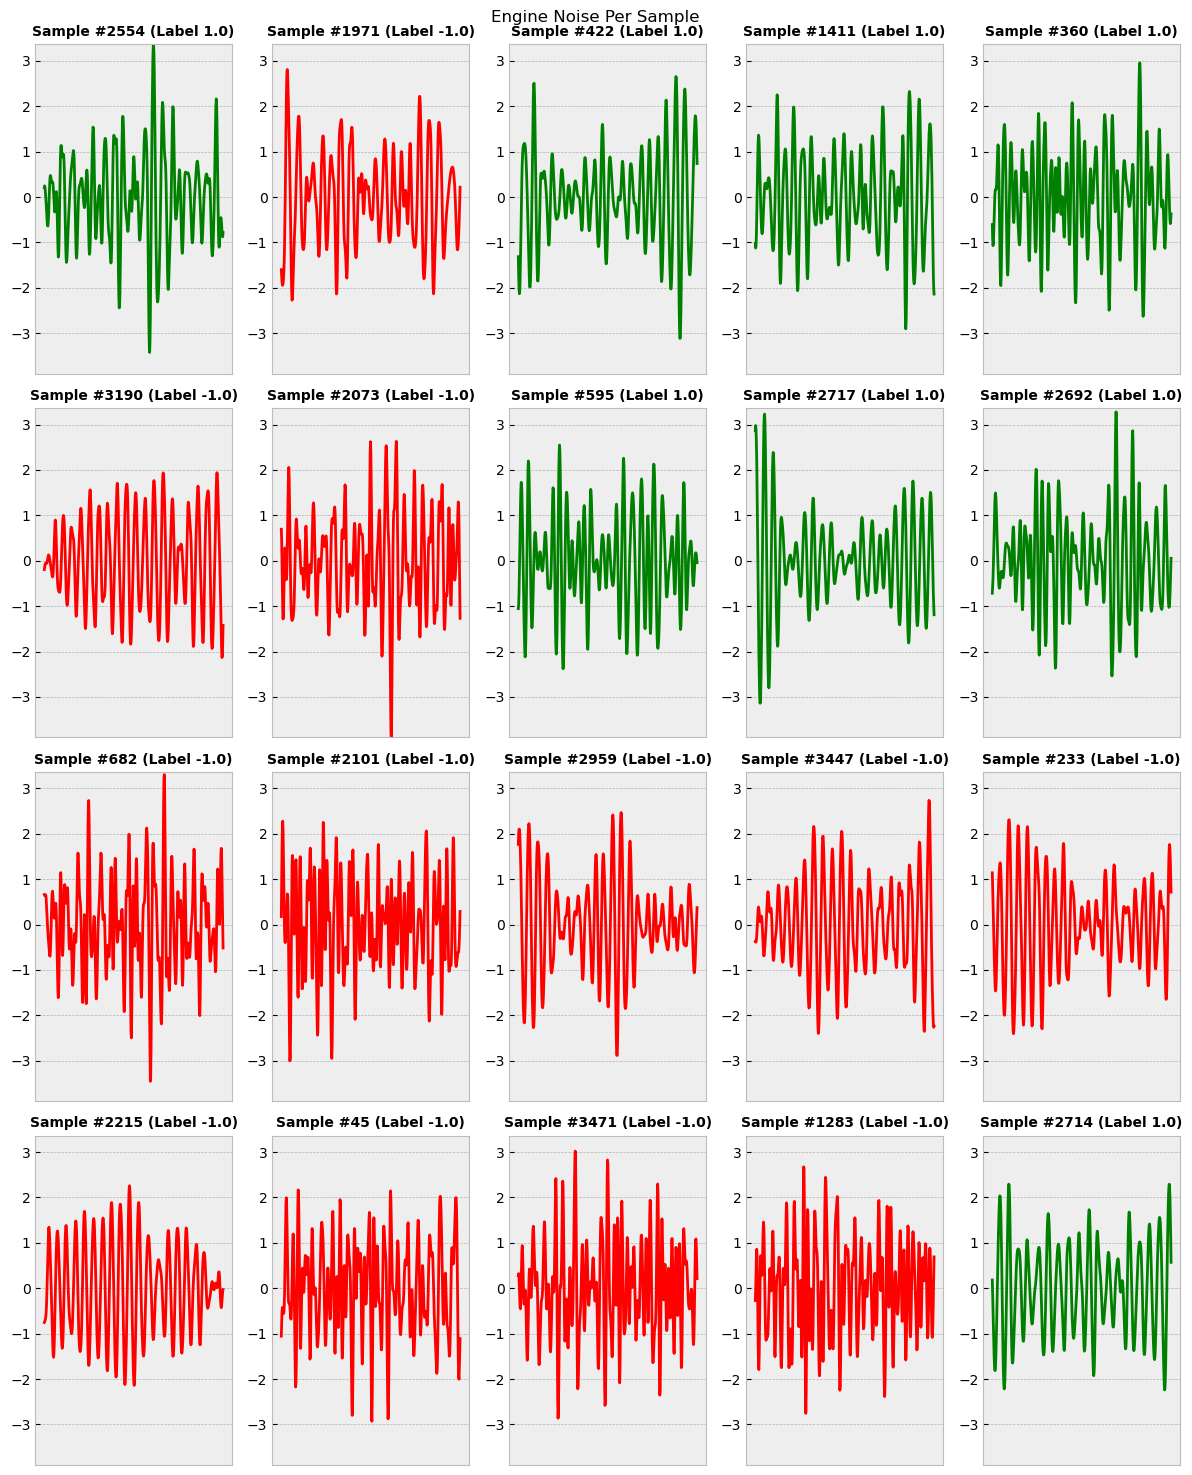

In [17]:
plt.figure(figsize=(3 * N_ROWS, 3 * N_COLS))

cmap = {-1:'r', 1:'g'}
y_bounds = samples.loc[:,'val_1':'val_500'].values.min(), samples.loc[:,'val_1':'val_500'].values.max()

for si, (sidx, sample) in enumerate(samples.iterrows(), start=1):
    # plot one sample here on a corresponding subplot
    ax = plt.subplot(N_ROWS, N_COLS, si, ylim=y_bounds)
    ax.set_xticks([]) # time values are uniform as far as I can tell
    ax.set_title(f"Sample #{sidx} (Label {sample['label']})", fontweight="bold", size=10)
    plt.plot(train.loc[sidx, 'val_1':'val_500'], c=cmap[sample['label']])

plt.suptitle('Engine Noise Per Sample')

plt.tight_layout();

# Task 2: explore statistics

In this task you need to plot simple statistics for each class, i. e. calculate `mean`, `median`, `std` and other statistics (of your choice) for each row and then visualize them in such a way, that one can figure out if a distribution of a given statistics differs between class `1` and `-1`.

**Hint:** you can consider [violin plots](https://seaborn.pydata.org/examples/grouped_violinplots.html) or [scatter plot matrix](https://seaborn.pydata.org/examples/scatterplot_matrix.html) helpful.

## Example: median

In [18]:
train["data_median"] = train.filter(like="val_").median(axis=1)
test["data_median"] = test.filter(like="val_").median(axis=1)

The simplest visualization possible (you need to create smth more elaborated for other features altogether):

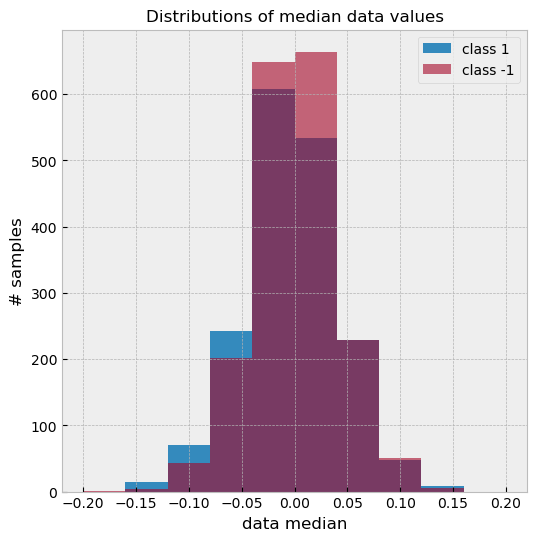

In [19]:
train.loc[train["label"]==1, "data_median"].plot(kind="hist", range=(-0.2, 0.2), label="class 1")
train.loc[train["label"]==-1, "data_median"].plot(kind="hist", range=(-0.2, 0.2), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("data median")
plt.ylabel("# samples")
plt.title("Distributions of median data values", fontsize=12);

**Note:** we can easily check if median is a good feature with ROC curve and score (as they do not rely on any specific normalization of the "predicted" probabilities). Think on why we're using `-data_median`.

In [20]:
fpr, tpr, thr = roc_curve(train["label"], -train["data_median"])

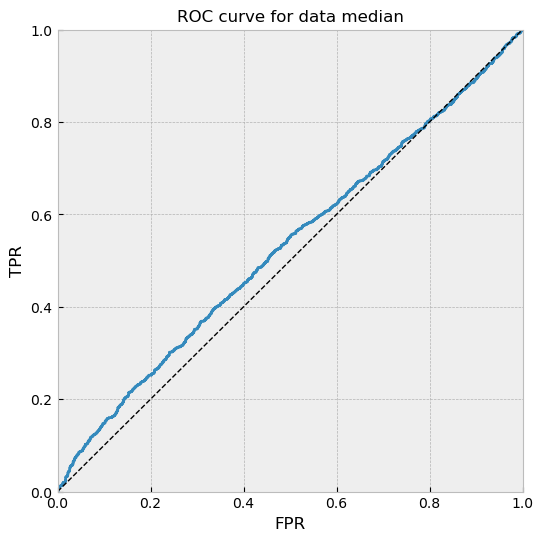

In [21]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for data median", fontsize=12);

Ok, median contains *some* information (i. e. looking at median values is better than random classifier), but cannot serve as a *single* feature.

## Exploration

In [22]:
def plot_roc_curve(labels, metric, name, ax=None):
    
    fpr, tpr, thr = roc_curve(labels, metric)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC curve for data {name}", fontsize=12);


vals_only = train.filter(like='val_')

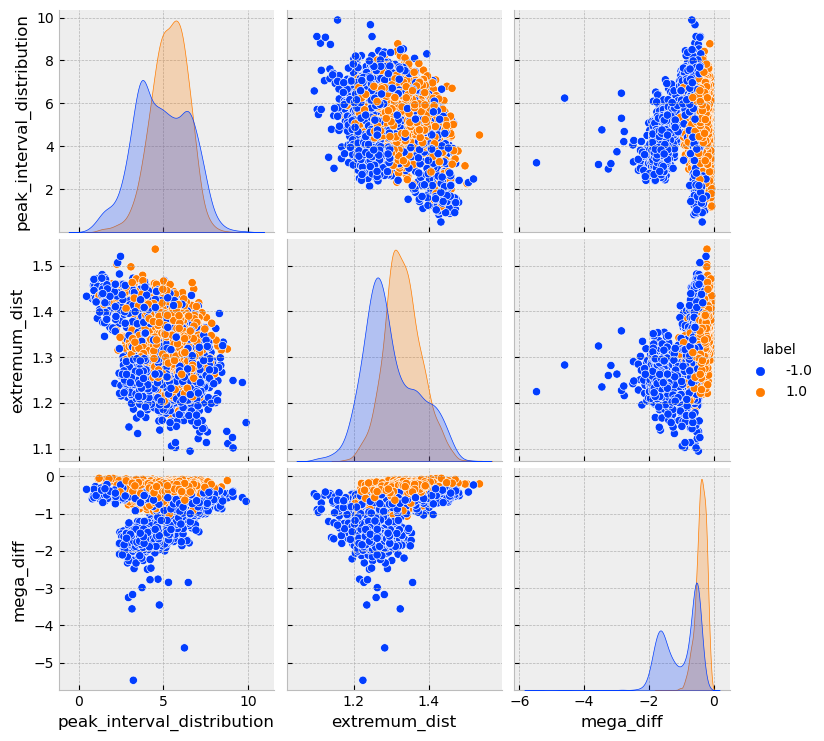

In [23]:
from scipy import stats
from scipy.signal import find_peaks

plot_it_like_its_hot = pd.DataFrame()
plot_it_like_its_hot['label'] = train['label']
plot_it_like_its_hot['peak_interval_distribution'] = [np.diff(find_peaks(vals_only.loc[r,:])[0]).std() for r in range(vals_only.shape[0])]
diffs = vals_only.diff(axis=1)
plot_it_like_its_hot['extremum_dist'] = vals_only[((diffs.gt(0) & diffs.shift(-1, axis=1).lt(0)) | 
                                                   (diffs.lt(0) & diffs.shift(-1, axis=1).gt(0)))].std(axis=1)
plot_it_like_its_hot['mega_diff'] = -np.abs(np.diff(vals_only, n=10, axis=1)).mean(axis=1)
sns.pairplot(plot_it_like_its_hot, hue='label', palette='bright');

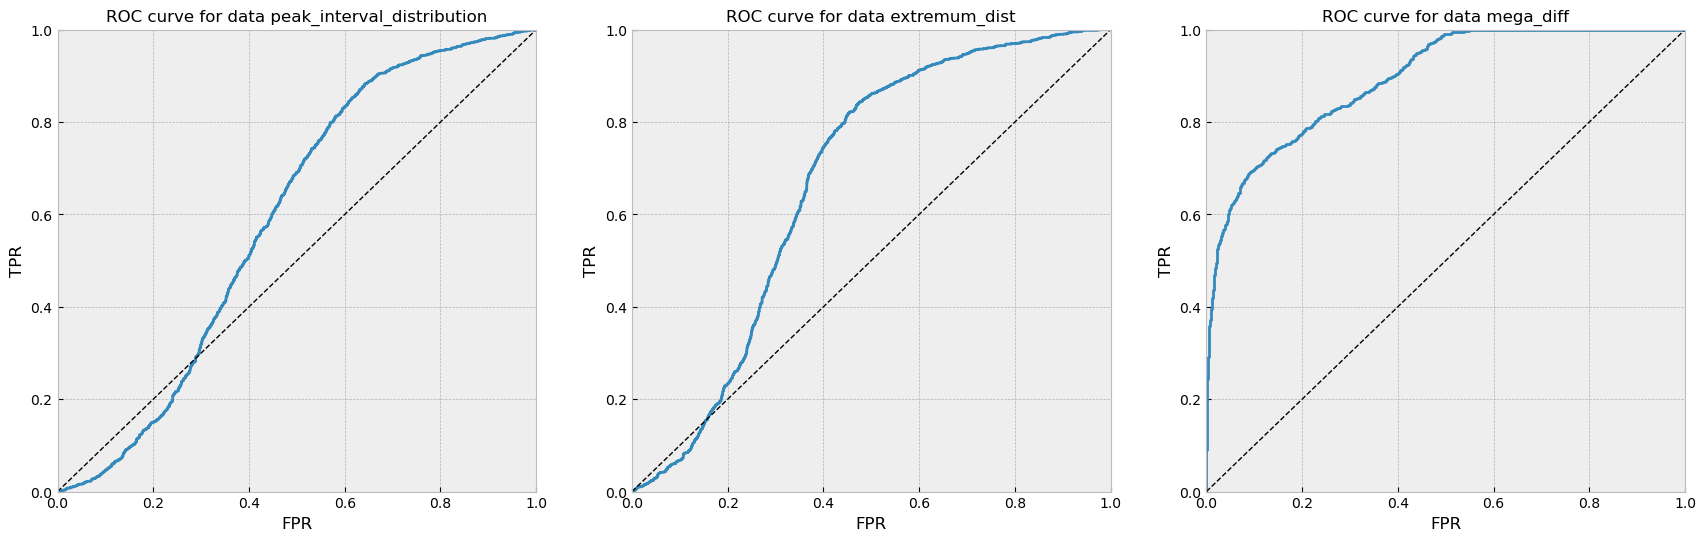

In [24]:
plt.figure(figsize=(21,6))
for i, c in enumerate(plot_it_like_its_hot.columns[1:], start=1):
    plt.subplot(1, 3, i)
    plot_roc_curve(plot_it_like_its_hot['label'], plot_it_like_its_hot[c], c)

# Task 3: explore advanced features

In this task you need to calculate and analyze other time series features. looking on the data sample, think on which features in time/frequency domains may be useful for a classification of the dataset.

**Hint:** try various features from [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

## Example: 0-crossings

For this features we'll not use `tsfresh`, and will do some ninja stuff in Pandas itself:

**Step 1:** mask on `> 0`.

In [25]:
mask = (train.filter(like="val_") > 0).astype(int)
mask

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,1,0,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,0,0,0
3597,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3598,0,0,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,0,0,0
3599,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0


**Step 2:** calc `diff` to get crossings (from `< 0` to `> 0`, or other way around).

In [26]:
mask.diff(axis=1) == 1  # crossing from -0 to +0

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3597,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3598,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3599,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [27]:
mask.diff(axis=1) == -1  # crossing from +0 to -0

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3597,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3598,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3599,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


**Step 3:** calculate counts.

In [28]:
train["zero+"] = (mask.diff(axis=1) == 1).sum(axis=1)
train["zero-"] = (mask.diff(axis=1) == -1).sum(axis=1)

In [29]:
train["zero+"]

0       18
1       19
2       17
3       22
4       34
        ..
3596    21
3597    21
3598    32
3599    21
3600    20
Name: zero+, Length: 3601, dtype: int64

**Note:** we do not need to perform any normalization, as all samples have the same length.

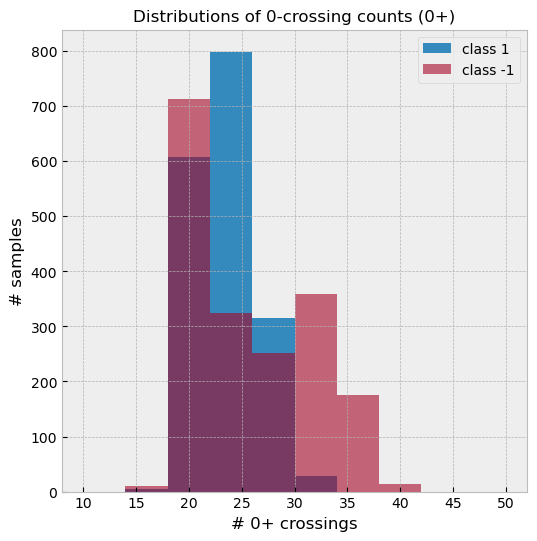

In [30]:
train.loc[train["label"]==1, "zero+"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero+"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0+ crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0+)", fontsize=12);

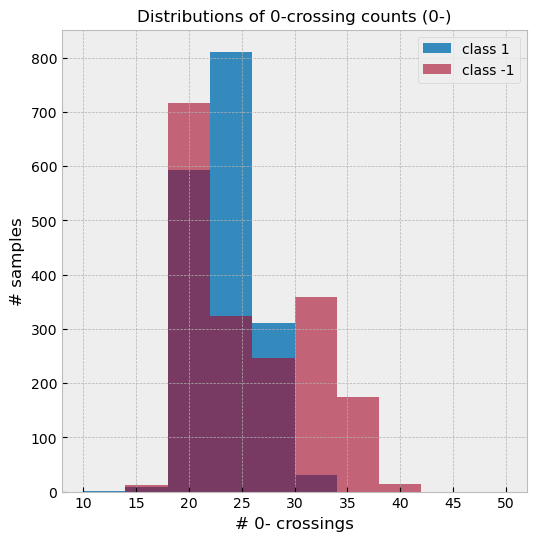

In [31]:
train.loc[train["label"]==1, "zero-"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero-"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0- crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0-)", fontsize=12);

Of course, for oscillatory time series `zero+` and `zero-` are highly correlated, so we may drop one of them:

In [32]:
train.filter(like="zero").corr()

,zero+,zero-
zero+,1.000000,0.988801
zero-,0.988801,1.000000


In [33]:
train.drop("zero-", axis=1, inplace=True)

The distribution of `zero+` looks fancy, and ROC curve reflects that:

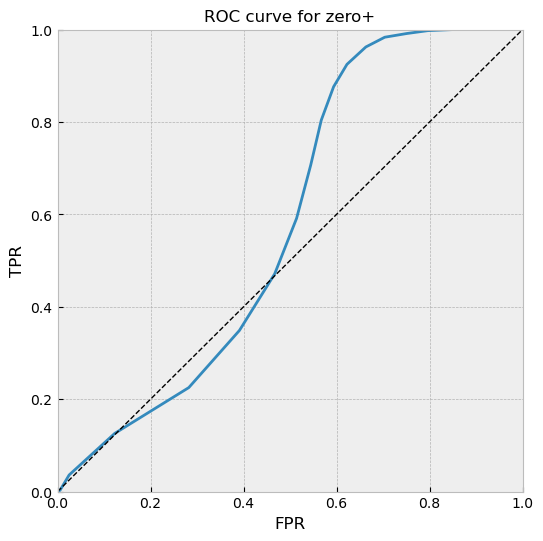

In [34]:
fpr, tpr, thr = roc_curve(train["label"], -train["zero+"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for zero+", fontsize=12);

Think on this in the following way.

Look at the histograms, and perform an estimate (no code, just in your head): given, that `zero+` is equal to `v`, what is the probability of a sample to belong to class `1`? Is this probability monotonic with `v`? How does this influence the choice of the model? Will logistic regression do the job here?

> The probability of a sample to belong to class `1` depends on the exact value of `v`. It is more likely when `v` is smaller than 20 and when it's greather than 30 (roughly), making it non-monotonic. 
>
> This also means the distirbution is multimodal, making logistic regression, and other models that assume linear decision boundary, a poor fit. 

## Exploration

In [35]:
# plot other features here - you may find various spectral features helpful here
# perform an analysis similar to one we did with number of 0-crossings
# beware of NaNs - some statistics may be broken for some rows

from tsfresh.feature_extraction.extraction import extract_features

def preprocess(data):
    out = data.reset_index().melt('index')
    out.columns = ['id','time','value']
    out['time'] = out.time.str.removeprefix('val_').astype(int)
    out.sort_values(['id','time'], inplace=True)
    return out

X_train = preprocess(vals_only)

params = {
    'autocorrelation': [{'lag':9}],
    'ar_coefficient':[{'coeff':1, 'k':10}],
    'spkt_welch_density':[{'coeff':5}],
    'number_peaks':[{'n':10}],
    'augmented_dickey_fuller': [{'attr': 'pvalue', 'autolag':'AIC'}]
    }
ts_features = extract_features(X_train, default_fc_parameters=params, column_id='id', column_value='value', n_jobs=6)

c:\Program Files\Anaconda3\envs\py4dp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Program Files\Anaconda3\envs\py4dp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
Feature Extraction: 100%|██████████| 30/30 [01:15<00:00,  2.51s/it]


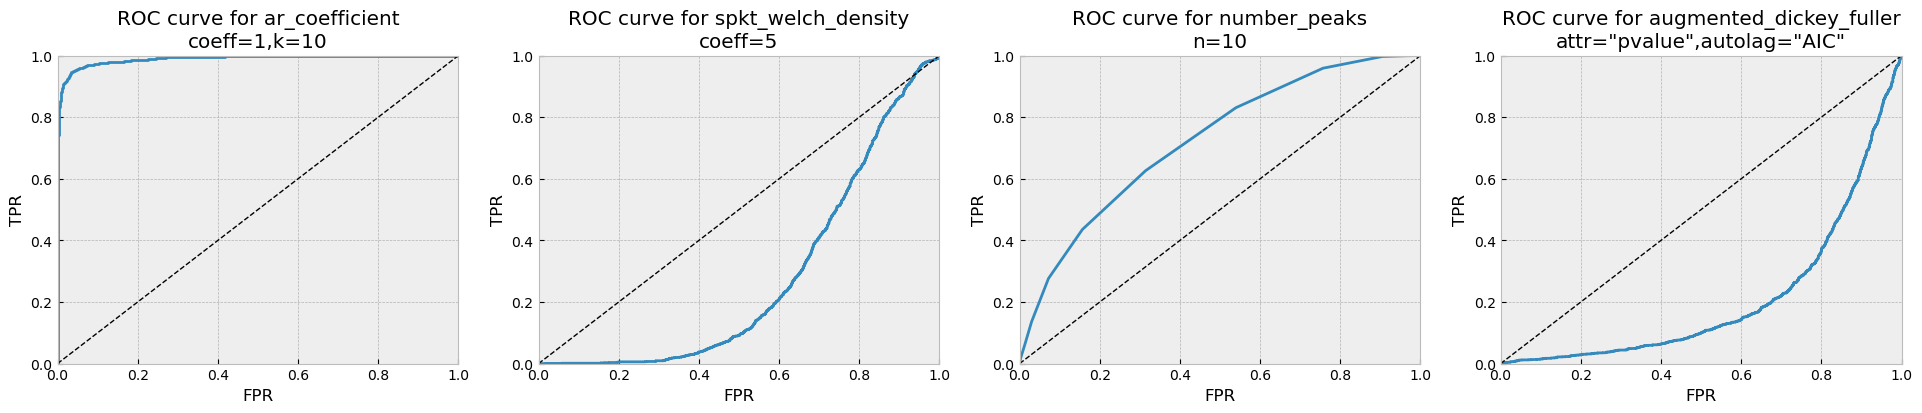

In [36]:
plt.figure(figsize=(30,4))
for i, c in enumerate(ts_features.columns[1:], start=1):
    
    properties = c.split('__')
    func = properties[1]
    args = ','.join([a.replace('_','=') for a in properties[2:]])
    
    ax = plt.subplot(1, 5, i)
    plot_roc_curve(train['label'], ts_features[c], '')
    ax.set_title(f'ROC curve for {func}\n{args}')

# Task 4: modeling

Given all the features you selected in Tasks 2 and 3, create a binary  classification model. You need to perform:

- reasonable train/validation split of `train`,
- select a model type (out of those, available in `sklearn`, no need to go for, say, gradient boosting),
- train a model, validate it and calculate the final score (ROC AUC) for the test set.

In [37]:
# do the train/validation split
# train a model
# check the performance on the test set

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

pipe = make_pipeline(StandardScaler(), LinearSVC()).fit(ts_features, train['label'])

X_test = preprocess(test.loc[:,'val_1':'val_500'])
ts_features_test = extract_features(X_test, default_fc_parameters=params, column_id='id', column_value='value' , n_jobs=8)
f1 = f1_score(y_pred=pipe.predict(ts_features_test), y_true=test['label'])
auc = roc_auc_score(test['label'], pipe.predict(ts_features_test))
print(f'f1 score:{f1}\nauc score:{auc}')

Feature Extraction: 100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


f1 score:0.9654088050314464
auc score:0.9664881112420978
